In [2]:
#Import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

import keras
import tensorflow 
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalAveragePooling2D, Convolution2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image

from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from nnAudio.Spectrogram import CQT1992v2
import efficientnet.tfkeras as efn

2022-05-19 01:57:27.650136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 01:57:27.650194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
#Read in the training labels csv
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/home/ian.harry/tmp_abi/train/' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'
    



In [28]:
#Function to set a path to call in the data

def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "/home/ian.harry/tmp_abi/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [29]:
#Packages to visualise spectrogram

import librosa
import librosa.display
import random

In [81]:
#Function to create the spectrogram 

def visualize_sample_spectogram(
    _id, 
    target,
    signal_names=("Detector 1", "Detector 2", "Detector 3") 
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        # sr - sample rate
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)
        
    plt.suptitle(f" target: {target}", fontsize=16)
    

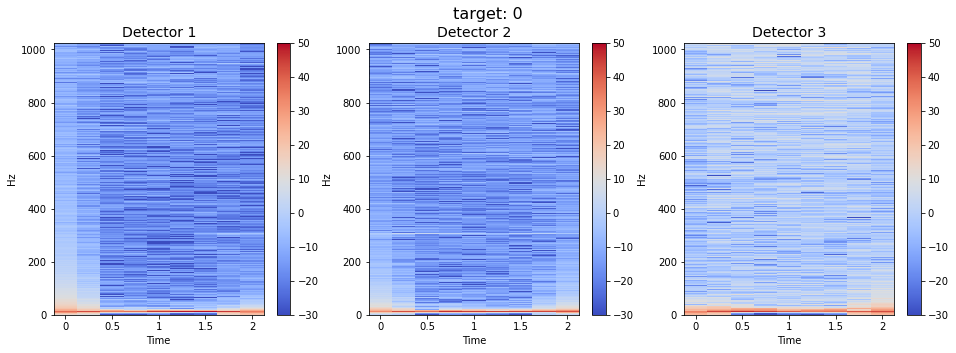

In [84]:
#Picks a randon data snippet to plot the spectrogram 
#target: 1  - signals is present, target: 0 - signal is not present. 
for i in random.sample(training_labels.index.tolist(), 1):
    _id = training_labels.iloc[i]["id"]
    target = training_labels.iloc[i]["target"]

    visualize_sample_spectogram(_id, target)
    spectro = plt.gcf()

In [85]:
spectro.savefig('spectro.pdf',format='pdf') # saves image as  a pdf 

In [42]:
# function to set a path to the data 
def path2id(idx,is_train = True):
    path = '/home/ian.harry/tmp_abi'
    if is_train:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    else:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    return path

In [43]:
#function to plot time series of each detector and for a q-scan.
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): 
    
    waves = np.load(path2id(idx,is_train))
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

CQT kernels created, time used = 0.0823 seconds


/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [144]:
gw_plot = np.load(path[2])

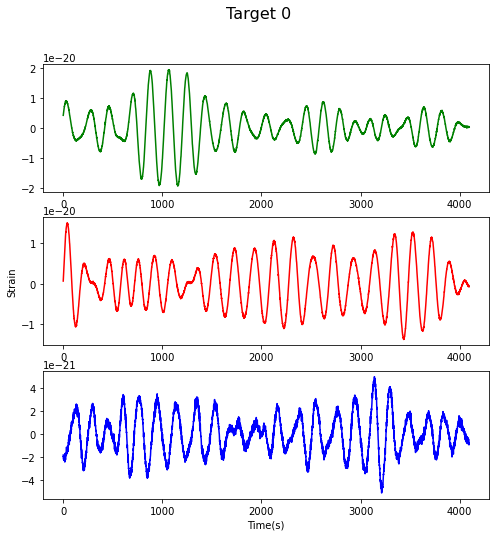

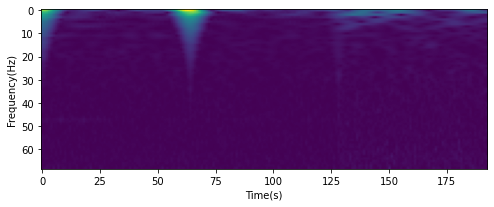

In [145]:
fig,a =  plt.subplots(3,1, figsize=(8,8))

a[0].plot(gw_plot[0],color='green')
a[1].plot(gw_plot[1],color='red')
a[2].plot(gw_plot[2],color='blue')
plt.xlabel('Time(s)')
plt.sca(a[1])
plt.ylabel('Strain')

ts_tar1 = plt.gcf()
plt.figure(figsize=(8,8))
plt.imshow(increase_dimension(training_labels['id'][2],is_train=True))
fig.suptitle('Target 0', fontsize=16)
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
q_tar1 = plt.gcf()


In [146]:
ts_tar1.savefig('ts_tar0.pdf',format='pdf')
q_tar1.savefig('q_tar0.pdf', format='pdf')